# Generating Recognition Evaluations

Here we will be run the recognition model to generate predicting features for the evaluation set. These predictions will be passed into the VLM judge in a later notebook to evaluate the predictive capablities of our model.

In [ ]:
%%capture
# Install required packages
!pip install git+https://github.com/huggingface/transformers
!pip install accelerate
!pip install torch
!pip install pandas
!pip install numpy
!pip install huggingface_hub[hf_transfer]
!pip install qwen-vl-utils[decord]==0.0.8

In [ ]:
import pandas as pd
import numpy as np

import os
import random
from PIL import Image as PIL_Image
import tempfile
import io
from pathlib import Path
from IPython.display import Image
from PIL import ImageEnhance
import json
from typing import Union, Dict, List

import torch
from huggingface_hub import hf_hub_download, snapshot_download
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

## Load Data in from Github
We will be using the images from the train set in https://github.com/alexeygrigorev/clothing-dataset-small.git. This dataset contains images most similar to what would be used in our product since they are user uploaded images of individual clothing items.

In [ ]:
# clone the repository of images
!git clone https://github.com/alexeygrigorev/clothing-dataset-small.git

# Define the path to the 'train' folder
train_folder = '/content/clothing-dataset-small/train'

# List the counts of each folders (classes) in the 'train' directory
class_folders = os.listdir(train_folder)
total_images = sum([len(os.listdir(os.path.join(train_folder, class_folder))) for class_folder in class_folders])
print(f"Total Number of Images: {total_images}")

for class_folder in class_folders:
    class_path = os.path.join(train_folder, class_folder)

    # Get the list of images in the current class folder
    images = os.listdir(class_path)
    num_images = len(images)

    # Print the number of images in the current class folder
    print(f"Class: {class_folder}, Number of images: {num_images}")

Cloning into 'clothing-dataset-small'...
remote: Enumerating objects: 3839, done.
remote: Counting objects: 100% (400/400), done.
remote: Compressing objects: 100% (400/400), done.
remote: Total 3839 (delta 9), reused 385 (delta 0), pack-reused 3439 (from 1)
Receiving objects: 100% (3839/3839), 100.58 MiB | 16.05 MiB/s, done.
Resolving deltas: 100% (10/10), done.
Total Number of Images: 3068
Class: pants, Number of images: 468
Class: longsleeve, Number of images: 455
Class: outwear, Number of images: 184
Class: t-shirt, Number of images: 795
Class: skirt, Number of images: 112
Class: dress, Number of images: 241
Class: shirt, Number of images: 290
Class: shorts, Number of images: 202
Class: hat, Number of images: 123
Class: shoes, Number of images: 198


Class: pants, Number of images: 468


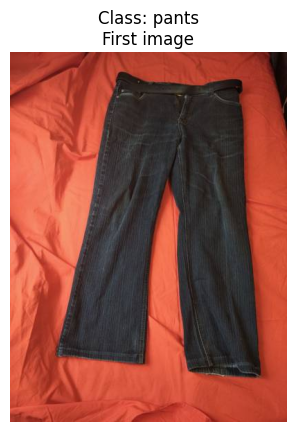

Class: longsleeve, Number of images: 455


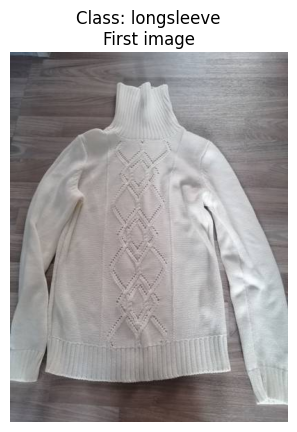

Class: outwear, Number of images: 184


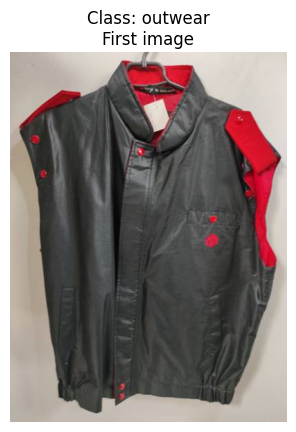

Class: t-shirt, Number of images: 795


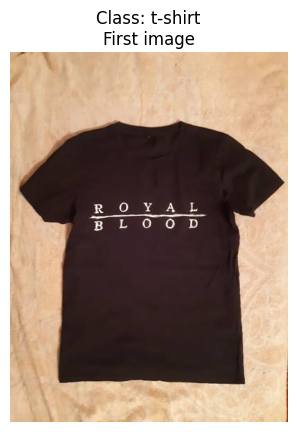

Class: skirt, Number of images: 112


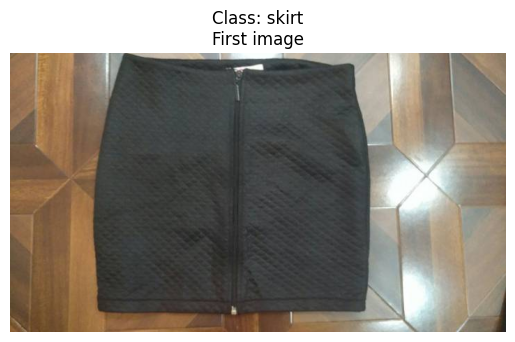

Class: dress, Number of images: 241


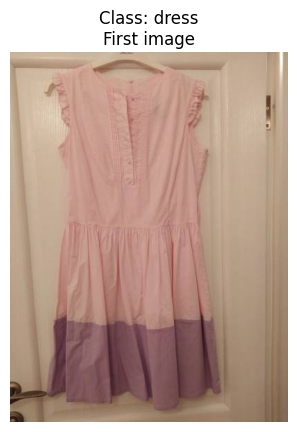

Class: shirt, Number of images: 290


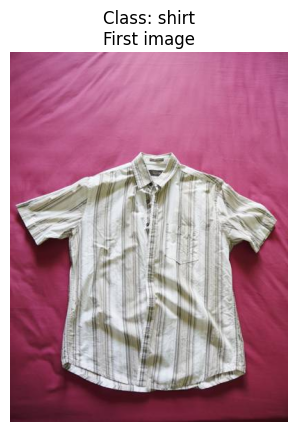

Class: shorts, Number of images: 202


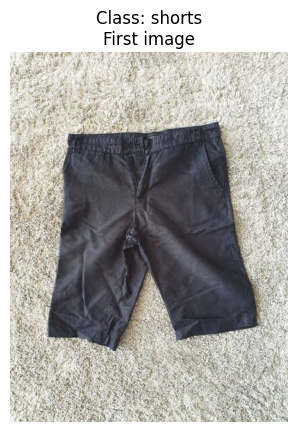

Class: hat, Number of images: 123


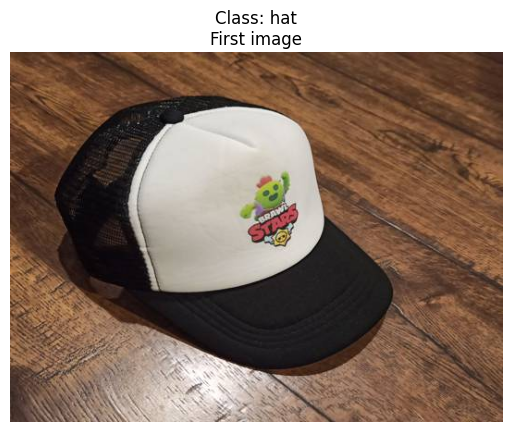

Class: shoes, Number of images: 198


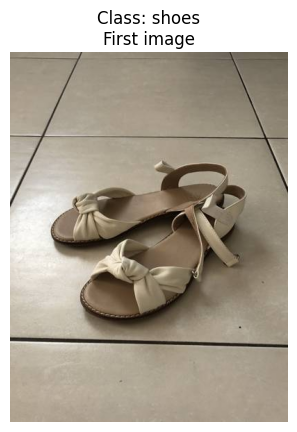

In [ ]:
# Step 3: Load and display some images (optional)
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for class_folder in class_folders:
    class_path = os.path.join(train_folder, class_folder)

    # Get the list of images in the current class folder
    images = os.listdir(class_path)
    num_images = len(images)

    # Print the number of images in the current class folder
    print(f"Class: {class_folder}, Number of images: {num_images}")

    # Display the first image from the current class folder
    if num_images > 0:
        first_image_path = os.path.join(class_path, images[0])
        img = mpimg.imread(first_image_path)

        plt.figure()
        plt.imshow(img)
        plt.axis('off')  # Hide the axes
        plt.title(f"Class: {class_folder}\nFirst image")
        plt.show()
    else:
        print(f"No images found in class: {class_folder}")

## Prepare model for eval

In [ ]:
# Define the model repository ID
repo_id = "Qwen/Qwen2.5-VL-7B-Instruct"

# Download the model file using hf_transfer
file_path = snapshot_download(repo_id)

print(f"Model downloaded to: {file_path}")

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

model-00001-of-00005.safetensors:   0%|          | 0.00/3.90G [00:00<?, ?B/s]

model-00002-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.37k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

model-00003-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

model-00005-of-00005.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

model-00004-of-00005.safetensors:   0%|          | 0.00/3.86G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.23k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Model downloaded to: /root/.cache/huggingface/hub/models--Qwen--Qwen2.5-VL-7B-Instruct/snapshots/6e6556e8ce728c7b3e438d75ebf04ec93403dc19


In [ ]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


## Define Recognition Prompt
Same one used in prev notebook (Recognition Sample Run) but removed the "How to style" feature as suggested by Daniel.

In [ ]:
prompt = """
You are a fashion expert and product description generator. Your task is to analyze clothing product images and generate detailed and accurate descriptions. Include the following attributes in your descriptions:
- Category (either Outerwear, Top, Bottom, or Footwear)
- Type of clothing
- Primary Color
- Accent Color(s)
- Pattern
- Shape
- Fit (e.g., slim-fit, oversized, relaxed, etc.)
- Neckline (e.g., Crew, v-neck, scoop, not applicable, etc.)
- Key design elements (describe relevant elements. e.g., buttons, zippers, pleats, embellishments, stitching patterns, etc.)
- Brand (if specified)
- Style (e.g., streetwear, minimalist, athleisure, classic/traditional, etc.)
- Occasion suitability (e.g., casual, formal, sporty, etc.)
- Weather appropriateness (e.g., warm, cold, all-season)
- Fabric Material (e.g., cotton, wool, silk, denim, etc.)
- Fabric Weight
- Functional Features (e.g. water resistant, moisture-wicking, insulated, etc.)
- Additional Notes (2-3 sentences describing the overall aesthetic of the piece and its essence)

Your descriptions should be professional and detailed enough to help a recommendation system that suggests outfit combinations based on occasion, style, and weather.
Format your response in JSON with the attribute name as the key and the corresponding description as the value.
"""

In [ ]:
def run_one_recognition(image_path):
  # define message with image and prompt
  messages = [
      {
          "role": "user",
          "content": [
              {
                  "type": "image",
                  "image": image_path,
              },
              {"type": "text", "text": prompt},
          ],
      }
  ]

  # Preparation for inference
  text = processor.apply_chat_template(
      messages, tokenize=False, add_generation_prompt=True
  )
  image_inputs, video_inputs = process_vision_info(messages)
  inputs = processor(
      text=[text],
      images=image_inputs,
      videos=video_inputs,
      padding=True,
      return_tensors="pt",
  )
  inputs = inputs.to("cuda")

  # Inference: Generation of the output
  generated_ids = model.generate(**inputs, max_new_tokens=512)
  generated_ids_trimmed = [
      out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
  ]
  output_text = processor.batch_decode(
      generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
  )

  # return description
  return output_text[0]

In [ ]:
def is_png_or_jpeg(file_path):
    # Check if the file extension is .png (case-insensitive)
    suffix = Path(file_path).suffix.lower()
    return suffix == '.png' or suffix == '.jpeg' or suffix == '.jpg'

In [ ]:
# Initialize lists to store image paths and descriptions
image_paths = []
descriptions = []

# Loop through all class folders in the 'train' directory
for class_folder in os.listdir(train_folder):
    # skip hat class since not in scope for our project
    if class_folder == 'hat':
        continue

    class_path = os.path.join(train_folder, class_folder)

    # Ensure it's a directory
    if os.path.isdir(class_path):
        # Loop through all files in the class folder
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)

            # Check if it's a file and a PNG/JPEG image
            if os.path.isfile(file_path) and is_png_or_jpeg(file_path):
                # Process the image and get the description
                description = run_one_recognition(file_path)

                # Append the file path and description to the lists
                image_paths.append(file_path)
                descriptions.append(description)

# Create a DataFrame from the collected data
eval_set = pd.DataFrame(
    {'image_path': image_paths,
     'json_string': descriptions
    })

# Display the first 5 rows of the DataFrame
eval_set.head(5)

,image_path,json_string
0,/content/clothing-dataset-small/train/pants/9f...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o..."
1,/content/clothing-dataset-small/train/pants/65...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o..."
2,/content/clothing-dataset-small/train/pants/f6...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o..."
3,/content/clothing-dataset-small/train/pants/17...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o..."
4,/content/clothing-dataset-small/train/pants/4e...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o..."


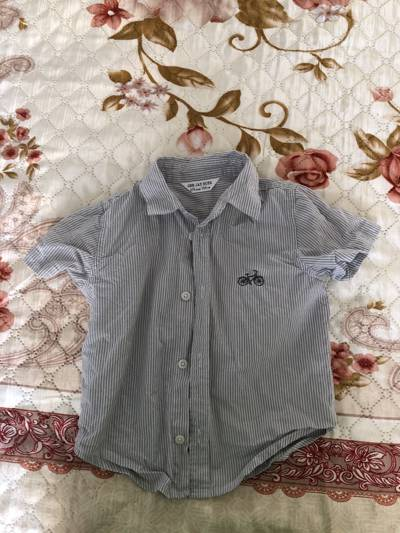

```json
{
  "Category": "Top",
  "Type of clothing": "Button-down shirt",
  "Primary Color": "Gray",
  "Accent Color(s)": "White",
  "Pattern": "Striped",
  "Shape": "Classic",
  "Fit": "Relaxed",
  "Neckline": "Collared",
  "Key design elements": "Buttons, short sleeves, embroidered bicycle patch",
  "Brand": "John Lewis",
  "Style": "Classic/traditional",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "Warm",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Lightweight",
  "Functional Features": "Not applicable",
  "Additional Notes": "This button-down shirt features a classic striped pattern with a subtle blue and white design. The embroidered bicycle patch adds a playful touch, making it suitable for casual outings or everyday wear."
}
```




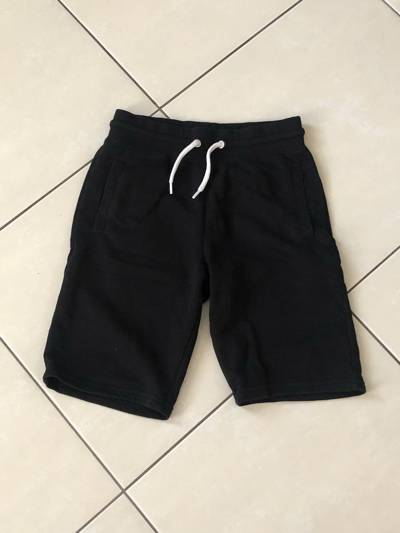

```json
{
  "Category": "Bottom",
  "Type of clothing": "Shorts",
  "Primary Color": "Black",
  "Accent Color(s)": "White",
  "Pattern": "Solid",
  "Shape": "Straight",
  "Fit": "Relaxed",
  "Neckline": "Not applicable",
  "Key design elements": "Drawstring waistband, pockets",
  "Brand": "Not specified",
  "Style": "Athleisure",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "Warm",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Medium",
  "Functional Features": "Not applicable",
  "Additional Notes": "These black shorts with white drawstrings and pockets offer a comfortable and versatile option for casual outings during warmer seasons. Their relaxed fit makes them suitable for everyday wear and leisure activities."
}
```




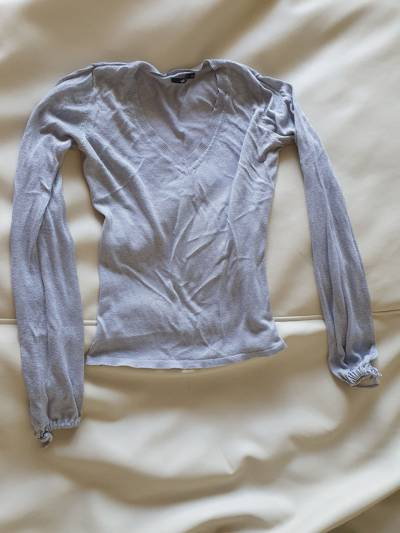

```json
{
  "Category": "Top",
  "Type of clothing": "Long-sleeved V-neck T-shirt",
  "Primary Color": "Light Gray",
  "Accent Color(s)": "None",
  "Pattern": "Solid",
  "Shape": "Slim-Fit",
  "Fit": "Slim-Fit",
  "Neckline": "V-neck",
  "Key design elements": "Simple, no embellishments or additional features",
  "Brand": "Not specified",
  "Style": "Minimalist",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "All-season",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Lightweight",
  "Functional Features": "Not applicable",
  "Additional Notes": "This long-sleeved V-neck T-shirt offers a sleek and versatile look suitable for everyday wear. Its slim fit and light gray color make it a great base layer or statement piece depending on the occasion."
}
```




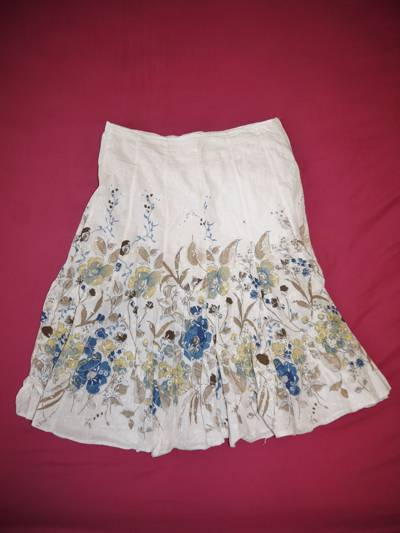

```json
{
  "Category": "Bottom",
  "Type of clothing": "Skirt",
  "Primary Color": "White",
  "Accent Color(s)": "Blue, Yellow, Brown",
  "Pattern": "Floral",
  "Shape": "A-line",
  "Fit": "Relaxed",
  "Neckline": "Not applicable",
  "Key design elements": "Embroidered floral pattern, pleated skirt",
  "Brand": "Not specified",
  "Style": "Casual",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "Warm",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Lightweight",
  "Functional Features": "Not applicable",
  "Additional Notes": "This skirt features a charming floral embroidery in soft pastel tones, making it perfect for a relaxed, springtime look. Its A-line shape and relaxed fit ensure comfort while adding a touch of elegance."
}
```




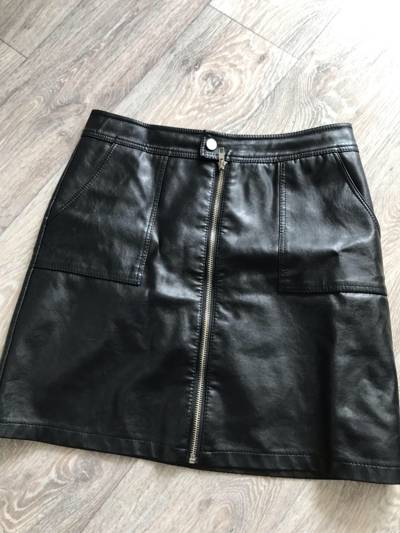

```json
{
  "Category": "Bottom",
  "Type of clothing": "Skirt",
  "Primary Color": "Black",
  "Accent Color(s)": "None",
  "Pattern": "Solid",
  "Shape": "A-line",
  "Fit": "Slim-fit",
  "Neckline": "Not applicable",
  "Key design elements": "Zipper front closure, two side pockets",
  "Brand": "Not specified",
  "Style": "Minimalist",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "All-season",
  "Fabric Material": "Leather",
  "Fabric Weight": "Medium",
  "Functional Features": "Water-resistant",
  "Additional Notes": "This black leather skirt features a sleek A-line silhouette with a zipper front closure and two side pockets, making it both stylish and practical for everyday wear."
}
```




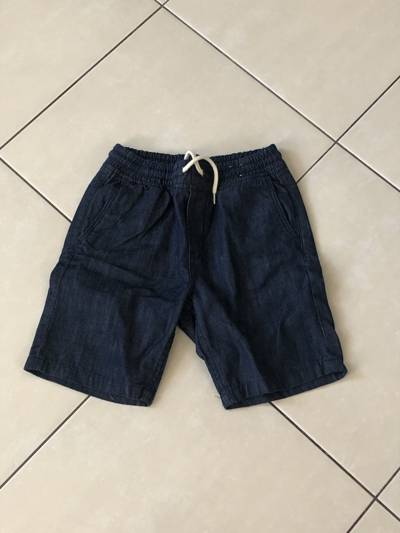

```json
{
  "Category": "Bottom",
  "Type of clothing": "Shorts",
  "Primary Color": "Dark Blue",
  "Accent Color(s)": "White",
  "Pattern": "Solid",
  "Shape": "Straight",
  "Fit": "Relaxed",
  "Neckline": "Not applicable",
  "Key design elements": "Drawstring waistband, side pockets",
  "Brand": "Not specified",
  "Style": "Minimalist",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "Warm",
  "Fabric Material": "Denim",
  "Fabric Weight": "Medium",
  "Functional Features": "Not water-resistant, not moisture-wicking, not insulated",
  "Additional Notes": "These shorts feature a simple yet stylish design with a drawstring waist for adjustable fit and side pockets for convenience. The dark blue color and relaxed fit make them suitable for casual outings during warmer seasons."
}
```




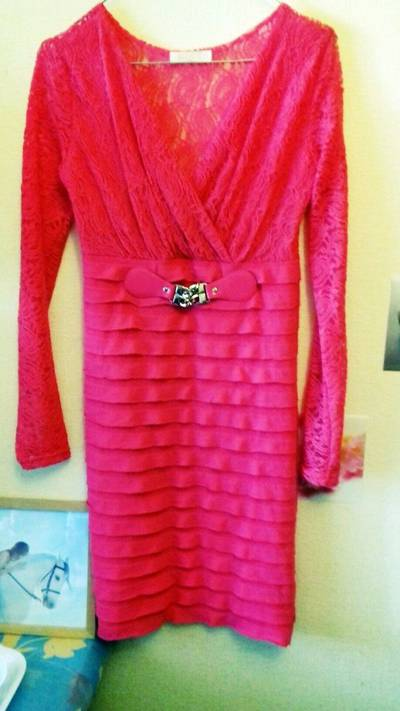

```json
{
  "Category": "Top",
  "Type of clothing": "Dress",
  "Primary Color": "Fuchsia",
  "Accent Color(s)": "Not applicable",
  "Pattern": "Solid",
  "Shape": "Column",
  "Fit": "Slim-Fit",
  "Neckline": "V-Neck",
  "Key design elements": "Long sleeves, ruffled waistband with decorative buckle, lace-like texture",
  "Brand": "Not specified",
  "Style": "Elegant",
  "Occasion suitability": "Formal",
  "Weather appropriateness": "Warm",
  "Fabric Material": "Lace",
  "Fabric Weight": "Lightweight",
  "Functional Features": "Not applicable",
  "Additional Notes": "This dress features a sophisticated lace-like texture and a ruffled waistband with a decorative buckle, making it perfect for formal occasions. The slim fit accentuates the wearer's figure while the long sleeves provide a touch of elegance."
}
```




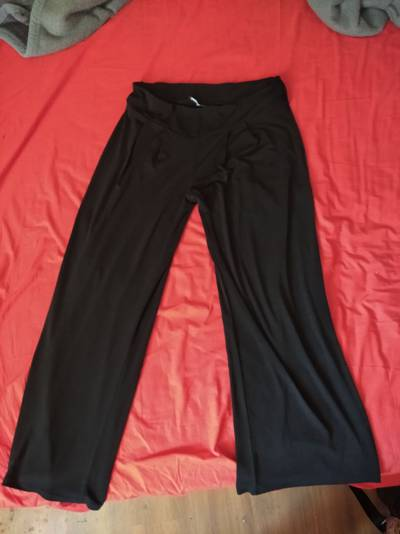

```json
{
  "Category": "Bottom",
  "Type of clothing": "Pants",
  "Primary Color": "Black",
  "Accent Color(s)": "None",
  "Pattern": "Solid",
  "Shape": "Straight leg",
  "Fit": "Relaxed",
  "Neckline": "Not applicable",
  "Key design elements": "Elastic waistband",
  "Brand": "Not specified",
  "Style": "Minimalist",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "All-season",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Medium",
  "Functional Features": "Not applicable",
  "Additional Notes": "The black straight-leg pants with an elastic waistband offer a comfortable and versatile option for everyday wear. Their relaxed fit makes them suitable for both casual outings and light athletic activities."
}
```




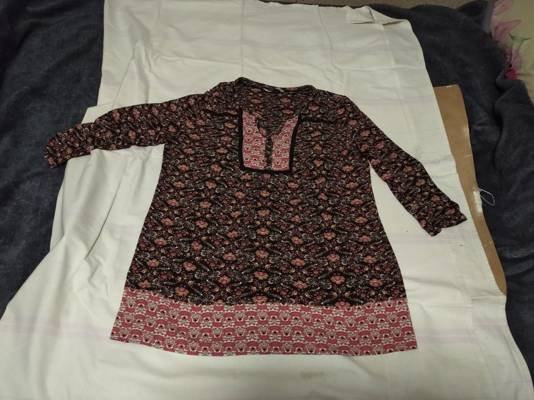

```json
{
  "Category": "Top",
  "Type of clothing": "Blouse",
  "Primary Color": "Brown",
  "Accent Color(s)": "Red, White",
  "Pattern": "Floral",
  "Shape": "Straight",
  "Fit": "Relaxed",
  "Neckline": "V-neck",
  "Key design elements": "Buttons at the front, contrasting border at the bottom",
  "Brand": "Not specified",
  "Style": "Classic/Traditional",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "All-season",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Lightweight",
  "Functional Features": "Not applicable",
  "Additional Notes": "This blouse features a relaxed fit with a V-neck and a floral pattern, making it versatile for various casual occasions. The contrasting border adds a touch of elegance, suitable for both everyday wear and light social events."
}
```




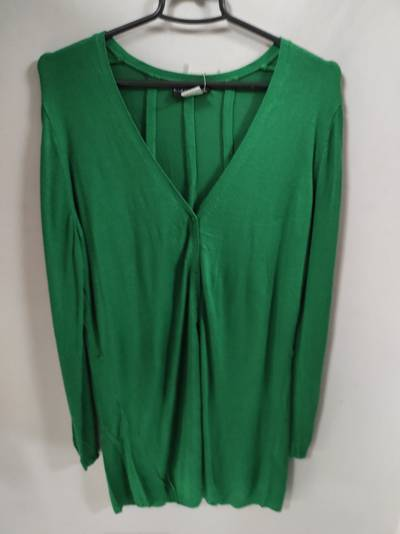

```json
{
  "Category": "Top",
  "Type of clothing": "Long-Sleeve Blouse",
  "Primary Color": "Green",
  "Accent Color(s)": "None",
  "Pattern": "Solid",
  "Shape": "Straight",
  "Fit": "Relaxed",
  "Neckline": "V-Neck",
  "Key design elements": "Deep V-neck, long sleeves, draped front panel",
  "Brand": "Not specified",
  "Style": "Minimalist",
  "Occasion suitability": "Casual",
  "Weather appropriateness": "All-season",
  "Fabric Material": "Cotton",
  "Fabric Weight": "Lightweight",
  "Functional Features": "None",
  "Additional Notes": "This long-sleeve blouse features a deep V-neck and a relaxed fit, making it versatile for various casual occasions. The draped front panel adds a touch of elegance without being overly formal."
}
```




In [ ]:
# visualize 10 images with generated description
for index, row in eval_set.sample(10).iterrows():
  image_path = row["image_path"]
  display(Image(filename=image_path))
  print(row['json_string'])
  print('\n')

## Post Process

In [ ]:
eval_set = pd.read_csv("/content/drive/MyDrive/MIDS Capstone/eval_set_predictions_1.csv")
eval_set.drop(columns=['Unnamed: 0'], inplace=True)
eval_set.head(5)

,image_path,json_string,Category,Type of clothing,Primary Color,Accent Color(s),Pattern,Shape,Fit,Neckline,Key design elements,Brand,Style,Occasion suitability,Weather appropriateness,Fabric Material,Fabric Weight,Functional Features,Additional Notes
0,/content/clothing-dataset-small/train/pants/9f...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Jeans,Dark Blue,NaN,Solid,Straight-Leg,Relaxed,Not applicable,"Belt loops, button fly, pockets",Not specified,Classic/Traditional,Casual,All-season,Denim,Medium,NaN,These jeans feature a relaxed fit with straigh...
1,/content/clothing-dataset-small/train/pants/65...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Pants,Blue,Black,Solid,Straight-leg,Relaxed,Not applicable,"Belt loops, pockets",Not specified,Casual,Casual,All-season,Cotton,Medium,Not applicable,The blue pants feature a relaxed fit with stra...
2,/content/clothing-dataset-small/train/pants/f6...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Jeans,Blue,White,Ripped,Straight,Slim-Fit,Not applicable,"Ripped details, button fly, pockets",Not specified,Casual,Casual,All-season,Denim,Medium,Not applicable,These jeans feature a slim fit with distinctiv...
3,/content/clothing-dataset-small/train/pants/17...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Pants,Dark Blue,Not applicable,Solid,Straight,Slim-fit,Not applicable,"Side pockets, subtle stitching details",Not specified,Minimalist,Casual,All-season,Cotton,Medium,Not applicable,These dark blue slim-fit pants feature subtle ...
4,/content/clothing-dataset-small/train/pants/4e...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Pants,Black,NaN,Solid,Straight leg,Relaxed,Not applicable,"Elastic waistband, side pockets",Not specified,Athleisure,Casual,All-season,Cotton,Medium,"Elastic waistband for comfort, side pockets fo...",These pants are designed for comfort and funct...


In [ ]:
import json
import pandas as pd

def clean_json_string(json_string):
    # Find the start and end of the valid JSON string
    start_index = json_string.find("{")
    end_index = json_string.rfind("}") + 1
    valid_json_string = json_string[start_index:end_index]
    return valid_json_string

def parse_output(json_string: str) -> pd.DataFrame:
    """
    Parse a JSON string into a pandas DataFrame.

    Args:
        json_string (str): A string containing JSON data

    Returns:
        pd.DataFrame: A pandas DataFrame containing the parsed data

    Raises:
        ValueError: If the JSON string is invalid or empty
        TypeError: If the JSON data structure is not compatible with DataFrame conversion
    """
    # Check if input is empty or None
    if not json_string or json_string.isspace():
        raise ValueError("Input JSON string is empty or None")

    try:
        # Extract the valid JSON string
        valid_json_string = clean_json_string(json_string)

        # Parse JSON string into Python object
        data = json.loads(valid_json_string)

        # Data should be a single dictionary
        if isinstance(data, dict):
            return pd.DataFrame([data])
        else:
            raise TypeError("JSON structure is not a dictionary.")

    except json.JSONDecodeError as e:
        print(f"Error parsing JSON for index {index}: {e}")
        print(f"Offending string: {json_string}")
        raise ValueError(f"Invalid JSON string: {str(e)}")
    except Exception as e:
        print(f"Error parsing JSON for index {index}: {e}")
        print(f"Offending string: {row['json_string']}")
        raise Exception(f"Error parsing JSON: {str(e)}")

In [ ]:
# add each attribute/property as a column to eval_set dataframe
for index, row in eval_set.iterrows():
  df = parse_output(row['json_string'])
  for column in df.columns:
    eval_set.loc[index, column] = df.loc[0, column]

eval_set.head(5)

,image_path,json_string,Category,Type of clothing,Primary Color,Accent Color(s),Pattern,Shape,Fit,Neckline,Key design elements,Brand,Style,Occasion suitability,Weather appropriateness,Fabric Material,Fabric Weight,Functional Features,Additional Notes
0,/content/clothing-dataset-small/train/pants/9f...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Jeans,Dark Blue,None,Solid,Straight-Leg,Relaxed,Not applicable,"Belt loops, button fly, pockets",Not specified,Classic/Traditional,Casual,All-season,Denim,Medium,None,These jeans feature a relaxed fit with straigh...
1,/content/clothing-dataset-small/train/pants/65...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Pants,Blue,Black,Solid,Straight-leg,Relaxed,Not applicable,"Belt loops, pockets",Not specified,Casual,Casual,All-season,Cotton,Medium,Not applicable,The blue pants feature a relaxed fit with stra...
2,/content/clothing-dataset-small/train/pants/f6...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Jeans,Blue,White,Ripped,Straight,Slim-Fit,Not applicable,"Ripped details, button fly, pockets",Not specified,Casual,Casual,All-season,Denim,Medium,Not applicable,These jeans feature a slim fit with distinctiv...
3,/content/clothing-dataset-small/train/pants/17...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Pants,Dark Blue,Not applicable,Solid,Straight,Slim-fit,Not applicable,"Side pockets, subtle stitching details",Not specified,Minimalist,Casual,All-season,Cotton,Medium,Not applicable,These dark blue slim-fit pants feature subtle ...
4,/content/clothing-dataset-small/train/pants/4e...,"```json\n{\n ""Category"": ""Bottom"",\n ""Type o...",Bottom,Pants,Black,None,Solid,Straight leg,Relaxed,Not applicable,"Elastic waistband, side pockets",Not specified,Athleisure,Casual,All-season,Cotton,Medium,"Elastic waistband for comfort, side pockets fo...",These pants are designed for comfort and funct...


In [ ]:
eval_set.tail(10)

,image_path,json_string,Category,Type of clothing,Primary Color,Accent Color(s),Pattern,Shape,Fit,Neckline,Key design elements,Brand,Style,Occasion suitability,Weather appropriateness,Fabric Material,Fabric Weight,Functional Features,Additional Notes
2935,/content/clothing-dataset-small/train/shoes/24...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Sneakers,Black,White,Solid,Standard athletic shoe shape,Standard fit,Not applicable,"Laces, Reebok logo, textured upper material",Reebok,Athletic/Streetwear,Casual,All-season,Canvas,Medium,Not specified,"These sneakers are designed for everyday wear,..."
2936,/content/clothing-dataset-small/train/shoes/38...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Sneakers,Black,White,Striped,Classic low-top,Standard,Not applicable,"Lace-up closure, striped fabric, white rubber ...",Not specified,Athleisure,Casual,All-season,Canvas,Lightweight,Comfortable for everyday wear,These sneakers feature a classic design with a...
2937,/content/clothing-dataset-small/train/shoes/43...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Shoe,Navy Blue,White,Solid,Round Toe,Standard,Not applicable,"Velcro strap, lace-up detail, white sole, perf...",GEOX,Athletic,Casual,All-season,Leather,Medium,Comfortable for everyday wear,These shoes are designed for comfort and style...
2938,/content/clothing-dataset-small/train/shoes/76...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Boot,Black,Dark Gray,Solid,Wedge Heel,Standard,Not applicable,"Zipper on the side, perforated panel on the si...",Not specified,Minimalist,Casual,Cold,Leather,Medium,Not applicable,These boots feature a sleek and modern design ...
2939,/content/clothing-dataset-small/train/shoes/bf...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Sneakers,Black,White,Solid,Round Toe,Standard,Not applicable,"Lace-up, leather upper, white sole, branded in...",Alben,Minimalist,Casual,All-season,Leather,Medium,Not applicable,These sneakers feature a sleek and modern desi...
2940,/content/clothing-dataset-small/train/shoes/45...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Shoes,Black,Gold,Studded grid,Classic Mary Jane style,Standard,Not applicable,"Studded grid pattern, adjustable strap with me...",Not specified,Classic/traditional,Casual,All-season,Leather,Medium,Not applicable,These shoes feature a timeless design with a s...
2941,/content/clothing-dataset-small/train/shoes/0a...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Sandals,Black,"White, Blue",Solid,Open-toe,Standard,Not applicable,"Straps, decorative beads, ankle strap",Calvin Klein,Classic/traditional,Casual,Warm,Suede,Medium,Comfortable for everyday wear,These sandals feature a classic design with a ...
2942,/content/clothing-dataset-small/train/shoes/f8...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Sandals,Black,None,Woven,Open-toe,Standard,Not applicable,"Straps, woven pattern, open toe",Not specified,Minimalist,Casual,Warm,Leather,Medium,Comfortable for everyday wear,"These sandals feature a sleek, minimalist desi..."
2943,/content/clothing-dataset-small/train/shoes/7d...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Slippers,Pink,"Blue, White, Pink",Striped,Open-toe,Relaxed,Not applicable,Strips of different colors across the top part...,Not specified,Casual,Casual,Warm,Plastic or synthetic,Lightweight,Comfortable for indoor use,These slippers are designed for comfort and st...
2944,/content/clothing-dataset-small/train/shoes/59...,"```json\n{\n ""Category"": ""Footwear"",\n ""Type...",Footwear,Shoes,Black,Brown,Solid,Boot,Standard,Not applicable,"Laces, stitching details, rubber sole",Not specified,Classic/Traditional,Casual,All-season,Leather,Medium,Comfortable for everyday wear,These shoes are versatile and suitable for bot...


In [ ]:
# save output as csv
eval_set.to_csv("/content/drive/MyDrive/MIDS Capstone/eval_set_predictions_1.csv")